## 1. Poisson's Equation

### Preliminaries

We're looking to solve Poisson's equation for electrostatics (given in dimensionless units, so that $\epsilon_{0} = 1$) on an $(N+1) \times (N+1)$ unit grid:

$$
  \Delta \phi = -\rho
$$

Here, $\rho$ is zero except at $\vec{x} = (0.5 + a/2, 0.25 + a/2)$, where it equals $2\delta(\vec{x})$. Since we're including points along the border, the distance between neighboring grid points is $h = 1/N$. We can express the discretized Laplacian, acting on the $N^2$-vector of potentials on the grid, as:

$$
  \Delta_{i,j} \phi_{j} = \frac{-4\phi_{i} + \phi_{i+1} + \phi_{i-1} + \phi_{i+N} + \phi_{i-N}}{h^2}
  = N^2 \Big(-4\phi_{i} + \phi_{i+1} + \phi_{i-1} + \phi_{i+N} + \phi_{i-N}\Big)
$$

so that the Laplacian matrix itself can be expressed in terms of Kronecker deltas as

$$
  \Delta_{i,j} = N^2 \Big(-4\delta_{i,j} + \delta_{i+1,j} + \delta_{i-1,j} + \delta_{i+N,j} + \delta_{i-N,j}\Big)
$$

which, it's worth noting, is a symmetric matrix. 

We have inhomogenous boundary conditions ($\phi = 10$) for the rectangle centered at (0.625, 0.75) and homogenous boundary conditions along the perimeter of the grid. Since these values of $\phi$ are fixed, they cannot figure into the $\Delta\phi=-\rho$ problem, in the sense that $\rho$ cannot be fixed if $\phi$ is held fixed (the equivalent physical analogy is the surface of a conductor in electrostatics). So for any _fixed_ $\phi_{i}$, we can set $\rho_{i} = 0 \implies \Delta_{i,j} = 0 \ \ \forall \ \ j$. In other words, for each $i$ such that $\phi_{i}$ is held constant, we set the $i^{th}$ row of $\Delta$ equal to zero. This assures us that $\phi$ only depends on $\rho$ through the boundary conditions.

Since the conjugate gradient method depends on the symmetry of a matrix, we'll have to deal with the nonzero terms in the $i^{th}$ _column_ of $\Delta$ before zeroing the $i^{th}$ row, which are:

$$
  \Delta_{j,i} = N^2 \Big(-4\delta_{i,j} + \delta_{i,j+1} + \delta_{i,j-1} + \delta_{i,j+N} + \delta_{i,j-N}\Big).
$$

Since these products are to be multiplied by the constant $\phi$ values, we can move them over to the right hand side of Poisson's equation. First, define $\beta_{i}$ so that it is one when $\phi_{i}$ is a boundary condition and zero otherwise. Then we split $\phi$ into fixed and free components

$$
  \vec{\phi} = \vec{\phi}_{free} + \vec{\phi}_{boundary}
$$

where

$$
  \vec{\phi}_{boundary} \equiv \sum_{i} \vec{\phi}^{T} \hat{e}_{i} \beta_{i}
$$

and $\vec{\phi}_{free} = \vec{\phi} - \vec{\phi}_{boundary}$. We can similarly split $\Delta$ by its columns,

$$
  \Delta = \Delta_{free} + \Delta_{boundary},
$$

so that the columns corresponding to boundary values in $\Delta_{free}$ are zero, i.e., independent of fixed quantities, implying $\Delta_{free} \vec{\phi}_{boundary} = \Delta_{boundary} \vec{\phi}_{free} = 0$. Then Poisson's equation becomes

$$
  \Delta_{free} \phi_{free} = -(\rho +\Delta_{boundary} \phi_{boundary}) \equiv -\rho_{boundary}
$$

where $\rho_{boundary}$ now contains the potential boundary conditions as well as the charge density. The left hand side is now free of fixed quantities; we can zero the boundary rows on both sides by taking the elemental product with the sum of free identity vectors

$$
  e_{free} \equiv \sum_{free\ i} \hat{e}_{i} 
$$

so that the equation becomes

$$
  \Delta_{eff} \phi_{free} \equiv \Delta_{free} \phi_{free} \ .\times\ e_{free} 
  = -\rho_{boundary} \ .\times\ e_{free} \equiv -\rho_{eff}.
$$

or, more briefly,

$$
  \Delta_{eff} \phi_{free} = -\rho_{eff}.
$$

Once we've solved for $\phi_{free}$ using the conjugate gradient method, we can reconstitute the original equation and, if necessary, calculate the values of $\rho$ that allowed for the boundary conditions.

I also partially implemented a feature that splits off the free parameters into their own Poisson equation, but haven't ended up finishing it. Since $\Delta_{eff}$, $\phi_{free}$, and $\rho_{eff}$ have zeros in every row (and column) associated with the boundary conditions, we can define minor matrices for each with those rows/columns removed entirely,

$$
  \Delta^\prime \phi^\prime = -\rho^\prime,
$$

along with an integer array, `freetofull`, with the same length as $\rho^\prime$ and which maps from its own indices to the corresponding indices in the original, full $\phi$ and $\rho$ vectors. This allows us to reduce the size of the problem and speed up the algorithm by making a clean distinction between the components of the potential representing boundary conditions and the components whose values we can actually optimize.

### Implementation

My Laplacian.jl module implements, in order of increasing abstraction:

* ($\delta$ or `kronecker`), __a Kronecker delta matrix function__ that takes arbitrary anonymous functions $f_i$ and $f_j$ (of row and column number, respectively) as arguments, and generates a matrix of arbitrary size whose elements are $\delta_{f_i,f_j}$, allowing for convenient translation of the above formulas
* (`lap`), __a Laplacian matrix function__ that uses `kronecker` along with the above formula for $\Delta$ to produce a Laplacian operator matrix for a square grid, given a particular side length and number of subdivisions in each direction.
* (`findfree`), __a function that produces an array mapping its indices to the free indices of the full matrix__ and which takes as its arguments the size of the full matrix ($N^2$) and a list of indices whose values are fixed as boundary conditions
* (`opsplit`), __a function for splitting $\Delta$ into free and boundary parts__ that takes an $N \times N$ Laplacian matrix (or, in general, a matrix) and an integer array giving the indices of boundary conditions, and returns the tuple ($\Delta_{free}$, $\Delta_{boundary}$) as output.
* (`rhoeff`), __a function for calculating $\rho_{eff}$__ that takes $\rho$, $\Delta_{boundary}$, $\phi_{boundary}$, and an array of the boundary condition indices as input.

My ConjugateGradient module implements:

* (`conjgrad`), __a conjugate gradient solver for $Ax = b$__ that takes $A$, $b$, and (optionally) a starting guess $x_{0}$ as input.

Representing the grid as a 2-d array makes it easier to visualize and easier to specify boundary conditions. I've used Julia's `reshape` function to convert the boundary conditions $\phi_{boundary}$ and the boundary locations $\beta$ to the appropriate 1-d array form.

__Going forward, I will drop the subscripts in the above version of Poisson's equation unless otherwise specified for the sake of simplicity.__ 

### Results

The algorithm worked well without the rectangle held at fixed potential:

#### $\phi$ without fixed potential
![Sans rectangle](p1-phi-sans-rectangle.svg)

It also worked with the fixed potential:

#### $\phi$ with fixed potential
![With potential, 1](p1-phi.svg)
![With potential, 2](p1-phi-2.svg)



## 2. Free particle Schrodinger equation

Most of the code from question 1 can still be used here. We are now trying to solve Schrodinger's equation,

$$
  E \psi = H \psi,
$$

where $H = -\frac{1}{2m}\Delta + V$ (using our choice of units such that $h=1$) and $V$ is infinite on the border and in the rectangle and is zero elsewhere. Since $m=1/10$, our equation becomes

$$
  -5\Delta \psi = E \psi
$$

within the region where $V = 0$; we can rephrase the infinite potential as a boundary condition on $\psi$, i.e. $\psi=0$ wherever $V \rightarrow \infty$. We can use our earlier code to find the matrix $\Delta_{eff}$ that reflects these boundary conditions. Then, we merely need to find the eigenvalues, which we can approximate using reverse iteration, i.e. through repeated application of the matrix

$$
  A^{-1}_{\mu} \equiv (-5\Delta_{eff} - \mu I)^{-1}
$$

so that, if there are any eigenvalues greater than 1 and close to $\mu$, their corresponding eigenvectors will grow after an application of $A^{-1}_{\mu}$. So, for any $\psi_{0}$ with $\|\psi_{0}\| = 1$, we should have

$$
  \psi_{1}^*\psi_{1} = \|A^{-1}_{\mu} \psi_{0}\|^2 >> 1
$$

whenever $\mu$ is near an eigenvalue. Since $-\Delta_{eff}$ is singular, we can't just invert it. We can, however, use the conjugate gradient method to solve

$$
  A_{\mu} \psi_{1} = \psi_{0}
$$

for $\psi_{1}$. We can then plot $\psi_{1}^*\psi_{1}$ against $\mu$ and look for peaks, which should correspond to eigenvalues of $-5\Delta_{eff}$, i.e. the allowed energies.

In [33]:
include("plot2.jl")
plots = plot2(intrvl);

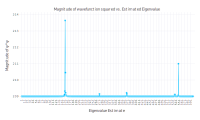

In [34]:
plots[1]

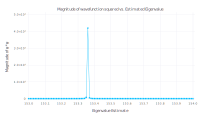

In [29]:
plots[2]

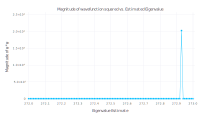

In [30]:
plots[3]

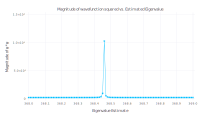

In [31]:
plots[4]

We can use the results from the first graph to narrow our search and get good estimates of the first three energy eigenvalues: $E_{1}=153.36$, $E_{2}=272.93$, and $E_{3}=368.46$. We then use the conjugate gradient method to solve $A_{\mu} \psi_{1} = \psi_{0}$ for $A_{E_{1}}$, $A_{E_{2}}$, and $A_{E_{3}}$, so that (after normalization), $\psi_{1}$ will be nearly parallel to the eigenvector of $-5\Delta_{eff}$ corresponding to eigenvalue $\mu$.